In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv  # hack for vs code jupyter extension

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Data.db_connection import get_connection

In [3]:
_ = load_dotenv("/mnt/HDD/Ivan/projects/FantasyPrediction/.envrc", override=True)

In [4]:
## Raw data gathering
player_data_sql = """
select 
	"PLAYER_NAME", "TEAM_ID", "GAME_ID", "MIN", "FGM", "FG_PCT", "FG3M", "FTM", "FT_PCT", "PTS", "AST" , "STL" , "DREB", "OREB", "BLK", "PLUS_MINUS", "NBA_FANTASY_PTS",
	"plus_minus" as "team_plus_minus", 
	plus_minus_rank as team_plus_minus_rank,
	"W_PCT_RANK" as team_w_pct_rank,
	gl.pts as team_points
from nba.box_score bs inner join nba.game_logs gl on bs."GAME_ID" = gl.game_id and bs."TEAM_ID" = gl.team_id ;
"""
df = pd.read_sql(player_data_sql, con=get_connection())
df.head()

,PLAYER_NAME,TEAM_ID,GAME_ID,MIN,FGM,FG_PCT,FG3M,FTM,FT_PCT,PTS,...,STL,DREB,OREB,BLK,PLUS_MINUS,NBA_FANTASY_PTS,team_plus_minus,team_plus_minus_rank,team_w_pct_rank,team_points
0,Amir Johnson,1610612738,21501217,21.616667,3,1.000,0,0,0.00,6,...,0,6,1,0,15,18.9,10.0,532,1,98
1,Marvin Williams,1610612766,21501219,9.800000,4,0.800,2,1,1.00,11,...,0,4,0,0,12,15.8,14.0,333,1,117
2,Jared Dudley,1610612764,21501221,33.366667,5,0.625,1,3,0.75,14,...,2,4,2,0,30,32.2,11.0,492,1,109
3,John Henson,1610612749,21501225,21.800000,3,0.333,0,1,0.50,7,...,0,3,1,1,-5,13.3,-5.0,1483,13074,92
4,Jorge Gutierrez,1610612766,21501219,17.816667,2,0.333,0,0,0.00,4,...,0,4,0,0,6,13.8,14.0,333,1,117


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78011 entries, 0 to 78010
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PLAYER_NAME           78011 non-null  object 
 1   TEAM_ID               78011 non-null  int64  
 2   GAME_ID               78011 non-null  int64  
 3   MIN                   78011 non-null  float64
 4   FGM                   78011 non-null  int64  
 5   FG_PCT                78011 non-null  float64
 6   FG3M                  78011 non-null  int64  
 7   FTM                   78011 non-null  int64  
 8   FT_PCT                78011 non-null  float64
 9   PTS                   78011 non-null  int64  
 10  AST                   78011 non-null  int64  
 11  STL                   78011 non-null  int64  
 12  DREB                  78011 non-null  int64  
 13  OREB                  78011 non-null  int64  
 14  BLK                   78011 non-null  int64  
 15  PLUS_MINUS         

## Model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def get_regression_metrics(model, X, y) -> dict:
    return dict(
        rmse=mean_squared_error(y, model.predict(X)),
        mape=mean_absolute_percentage_error(y, model.predict(X))
    )
target = "NBA_FANTASY_PTS"
features = [col for col in df.columns if col not in ["PLAYER_NAME", "TEAM_ID", "GAME_ID", "NBA_FANTASY_PTS"]]
# most basic, see if the box score and some team stats are predictive of nba fantasy points. No past games etc.
X_train, X_valid, y_train, y_valid = train_test_split(df[features], df[target], test_size=0.01, random_state=345, shuffle=True)

### Simple Visualization
Using a pariplot on 15+ features would not be meaningful to the human eye. <br/>
We should plot individual relationships with the most important features decided by DecisionTrees

[Text(0.5, 0.875, 'PTS <= 11.5\nsquared_error = 206.789\nsamples = 78011\nvalue = 20.98'),
 Text(0.25, 0.625, 'PTS <= 4.5\nsquared_error = 77.521\nsamples = 48689\nvalue = 12.879'),
 Text(0.125, 0.375, 'MIN <= 11.835\nsquared_error = 36.441\nsamples = 22919\nvalue = 6.919'),
 Text(0.0625, 0.125, 'squared_error = 11.589\nsamples = 11857\nvalue = 3.428'),
 Text(0.1875, 0.125, 'squared_error = 36.014\nsamples = 11062\nvalue = 10.661'),
 Text(0.375, 0.375, 'DREB <= 3.5\nsquared_error = 54.357\nsamples = 25770\nvalue = 18.18'),
 Text(0.3125, 0.125, 'squared_error = 34.19\nsamples = 16663\nvalue = 15.462'),
 Text(0.4375, 0.125, 'squared_error = 52.993\nsamples = 9107\nvalue = 23.154'),
 Text(0.75, 0.625, 'PTS <= 21.5\nsquared_error = 131.522\nsamples = 29322\nvalue = 34.432'),
 Text(0.625, 0.375, 'DREB <= 5.5\nsquared_error = 71.792\nsamples = 20745\nvalue = 29.955'),
 Text(0.5625, 0.125, 'squared_error = 52.219\nsamples = 15114\nvalue = 27.523'),
 Text(0.6875, 0.125, 'squared_error = 65.884

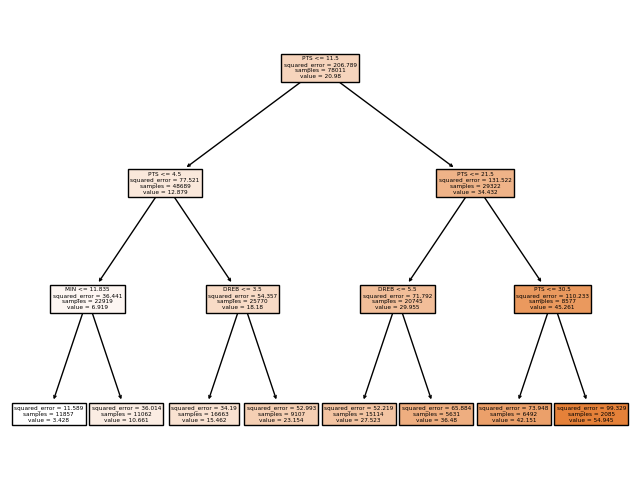

In [7]:
plt.figure(figsize=(8,6))
dtr = DecisionTreeRegressor(min_samples_split= 15, max_depth=3)
dtr.fit(df[features], df[target])
plot_tree(dtr, feature_names=dtr.feature_names_in_, filled=True)

<Figure size 1200x700 with 0 Axes>

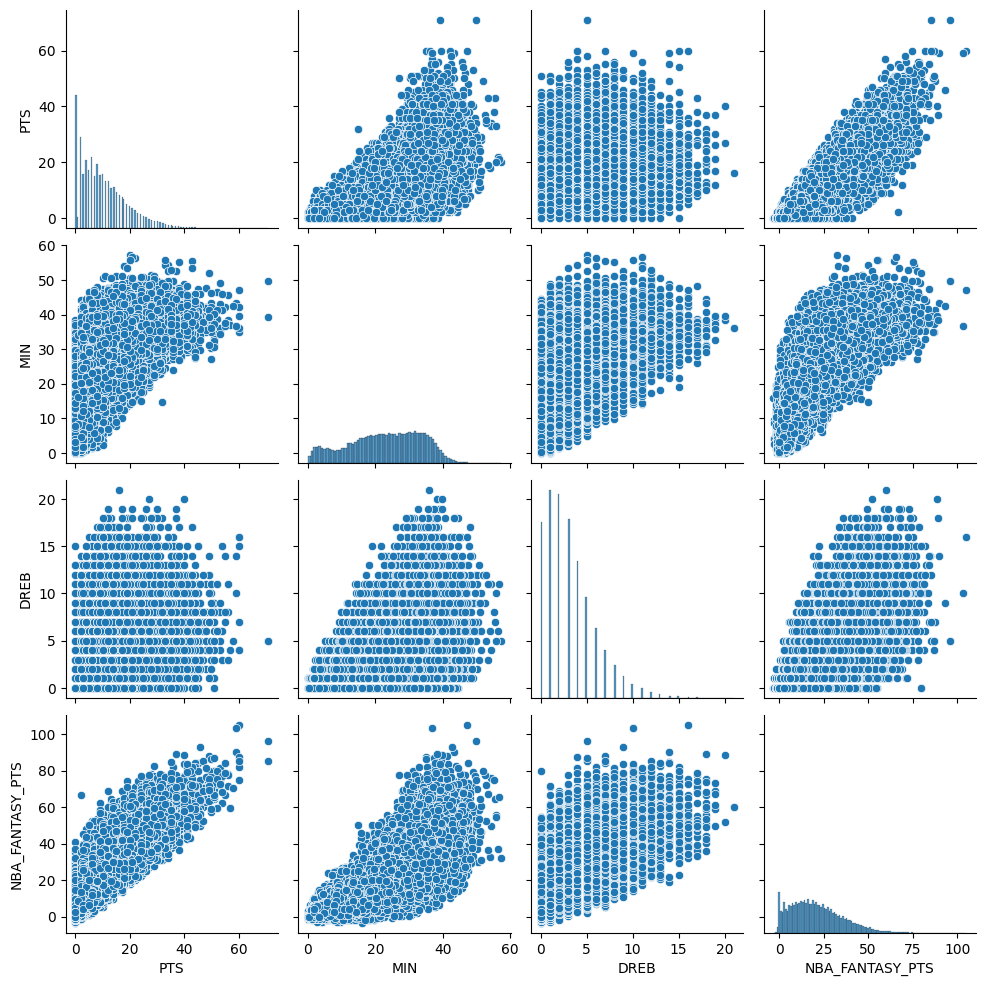

In [8]:
plt.figure(figsize=(12, 7))
sns.pairplot(df[['PTS', 'MIN', 'DREB', target]])

### Prediction
Looking at MSE for various modelsand look at predicted vs actual plot <br/>
to see if model predicts well - aka have a relationship between game stats and fantasy points

In [9]:
rfc = RandomForestRegressor(n_estimators=200, max_depth=16, n_jobs=4)
rfc.fit(X_train, y_train)
print("RFC: ", get_regression_metrics(rfc, X_valid, y_valid))

boosting_reg = GradientBoostingRegressor(n_estimators=200, min_samples_split=15)
boosting_reg.fit(X_train, y_train)
print("gradient boostingv2: ", get_regression_metrics(boosting_reg, X_valid, y_valid))

## PCA model
# scaler = StandardScaler()
# pca = PCA(n_components=4)
# pca_X_train = pca.fit_transform(scaler.fit_transform(X_train))
reg = ElasticNet(alpha=0.5, l1_ratio=0.25)
reg.fit(X_train, y_train)
print("elasticnet: ", get_regression_metrics(reg, X_valid, y_valid))

RFC:  {'rmse': 2.97946575335989, 'mape': 23875855120672.176}
gradient boostingv2:  {'rmse': 1.8506552766022084, 'mape': 22151455013409.684}
elasticnet:  {'rmse': 3.421225427361462, 'mape': 39506162834263.91}


<Axes: title={'center': 'sklearn.ElasticNet'}, ylabel='NBA_FANTASY_PTS'>

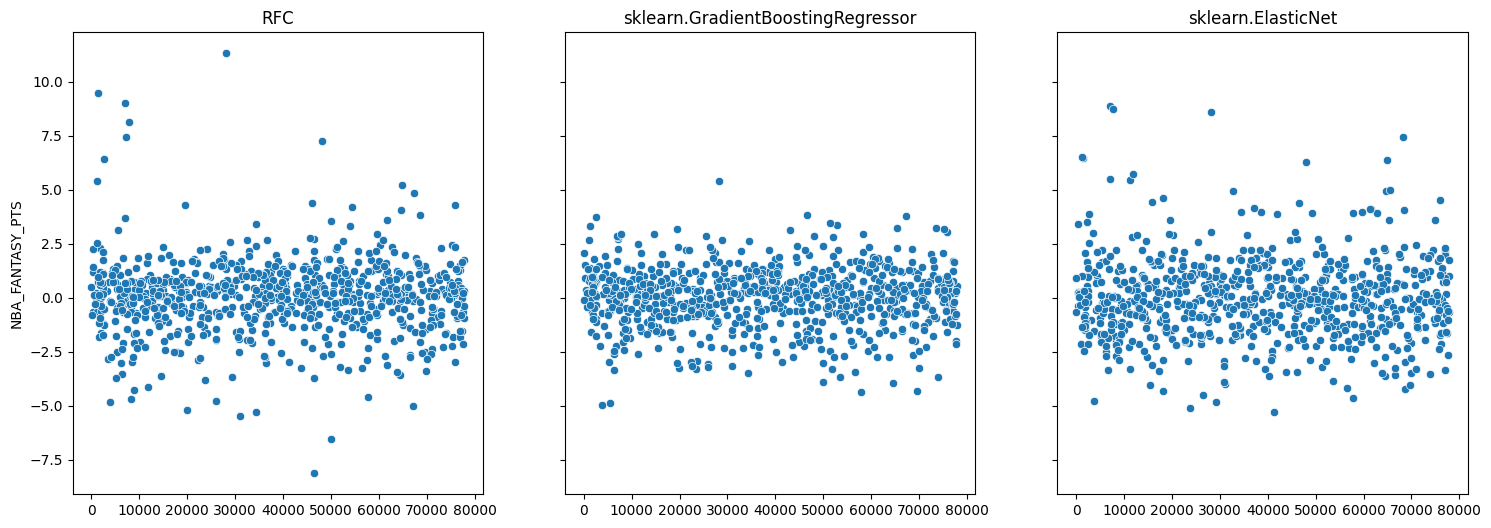

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
ax1.title.set_text("RFC")
sns.scatterplot(y_valid - rfc.predict(X_valid), ax=ax1)
ax2.title.set_text("sklearn.GradientBoostingRegressor")
sns.scatterplot(y_valid - boosting_reg.predict(X_valid), ax=ax2)
ax3.title.set_text("sklearn.ElasticNet")
sns.scatterplot(y_valid - reg.predict(X_valid), ax=ax3)

<Axes: title={'center': 'sklearn.ElasticNet'}>

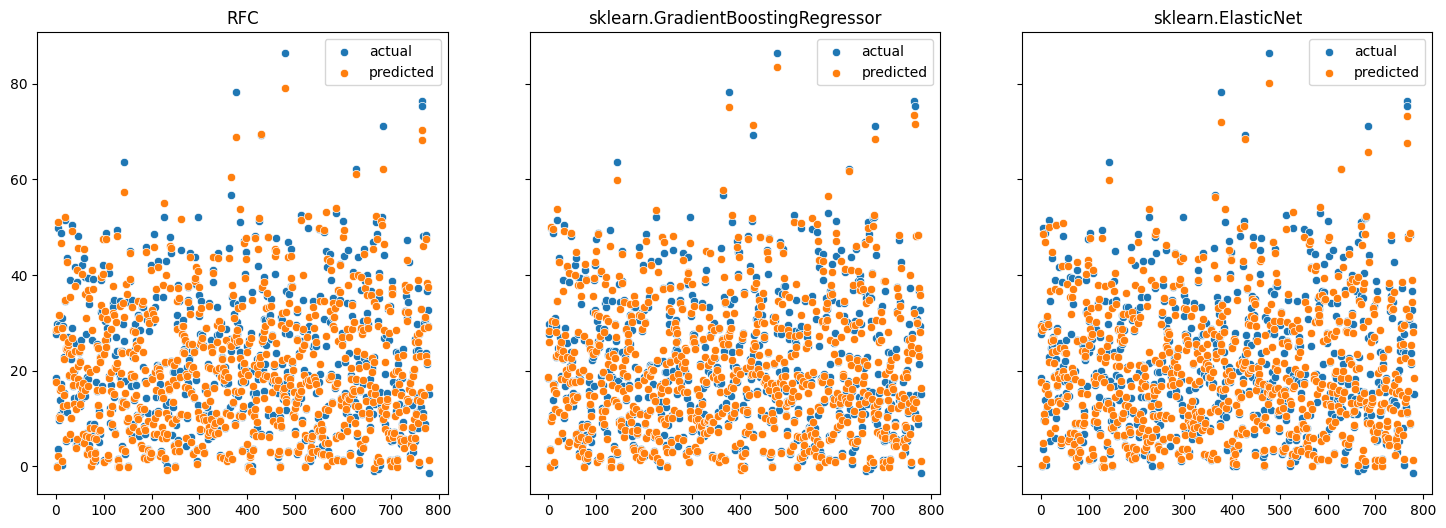

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
ax1.title.set_text("RFC")
sns.scatterplot(y_valid.values, ax=ax1, label="actual")
sns.scatterplot(rfc.predict(X_valid), ax=ax1, label="predicted")

ax2.title.set_text("sklearn.GradientBoostingRegressor")
sns.scatterplot(y_valid.values, ax=ax2, label="actual")
sns.scatterplot(boosting_reg.predict(X_valid), ax=ax2, label="predicted")
ax3.title.set_text("sklearn.ElasticNet")
sns.scatterplot(y_valid.values, ax=ax3, label="actual")
sns.scatterplot(reg.predict(X_valid), ax=ax3, label="predicted")